
# Portfolio Optimization: Classical Computing with MPT (Modern Potfolio Theory) versus Quantum Computing with VQE (Variational Quantum Eigensolver) 

In the first part, our portfolio optimization is based on MPT where we also use Sharp Ratio and later we take into account the risk aversion of the user and find the optimal portfolio with the highest return based on the volatility that will be entered by a user. Then in the second part, we will use a quantum computing approach with the VQE algorithm. We want to use the VQE algorithm, not the QAOA algorithm because VQE is more suitable for our current purposes as it requires less qubits than the QAOA algorithm. Thanks to IBM Quantum access we will be able to use quantum computers. 

# Classical Computing with MPT (Modern POrtfolio Theory)

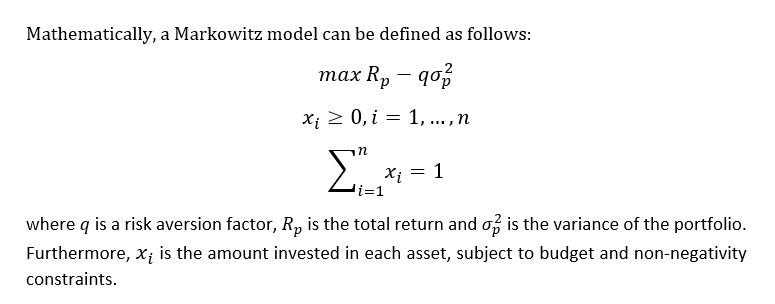

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import pandas_datareader as web

Here the users can write their assets for their portfolio:

In [51]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = []

while True:
    try:
        ticker = input("Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): ")
        
        if ticker == "end":
            break
        elif ticker.startswith("remove "):
            ticker_to_remove = ticker.split(" ")[1].upper()
            
            if ticker_to_remove in tickers:
                tickers.remove(ticker_to_remove)
                print(f"Removed {ticker_to_remove} from the portfolio.")
            else:
                print(f"{ticker_to_remove} is not in the portfolio.")
        else:
            stock = yf.Ticker(ticker)
            stock_data = stock.history(start="2018-01-01", end=None)
            
            if not stock_data.empty:
                stock_data['returns'] = stock_data['Close'].pct_change()
                
                tickers.append(ticker.upper())
            else:
                print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except:
        print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")

if tickers:
    portfolio_data = yf.download(tickers, start='2018-01-01')
    portfolio_returns = portfolio_data.pct_change().dropna()
    print(portfolio_data)
else:
    print("No tickers entered.")


Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): aapl
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): msft
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): jnj
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): pfe
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that

As an example we choosed 10 stocks from 5 different industries and 2 cryptocurrencies: 

Technology:

Apple Inc. (AAPL)
Microsoft Corporation (MSFT)

Healthcare:

Johnson & Johnson (JNJ)
Pfizer Inc. (PFE)

Financial Services:

JPMorgan Chase & Co. (JPM)
Bank of America Corporation (BAC)

Consumer Goods:

The Coca-Cola Company (KO)
Procter & Gamble Company (PG)

Energy:

Exxon Mobil Corporation (XOM)
Chevron Corporation (CVX)

Cryptocurrency: 
Bitcoin (BTC-USD)
Etherium (ETH-USD)

In [52]:
# Just study adj close 
portfolio_data = portfolio_data['Adj Close']
portfolio_data.dropna(inplace=True)
print(portfolio_data)

                  AAPL        BAC       BTC-USD         CVX      ETH-USD  \
Date                                                                       
2018-01-02   40.831593  26.632412  14982.099609  101.562263   884.443970   
2018-01-03   40.824478  26.543341  15201.000000  102.302605   962.719971   
2018-01-04   41.014111  26.890718  15599.200195  101.984169   980.921997   
2018-01-05   41.481060  27.015419  17429.500000  101.816978   997.719971   
2018-01-08   41.327000  26.828369  15170.099609  102.318504  1148.530029   
...                ...        ...           ...         ...          ...   
2022-03-18  162.767502  41.857346  41801.156250  156.363419  2945.343018   
2022-03-21  164.157150  41.798798  41077.996094  159.176865  2897.976562   
2022-03-22  167.571716  43.106232  42358.808594  158.645126  2973.131104   
2022-03-23  168.951462  42.042725  42892.957031  160.356415  3031.067139   
2022-03-24  172.782883  42.023205  43960.933594  160.781784  3108.062012   

           

Thanks to Correlation Matrix users can see the correlation of assets within the portfolio: 
it is worth to note that most of time portfolio owners desire not to include positive correlated assets within their portfolio.

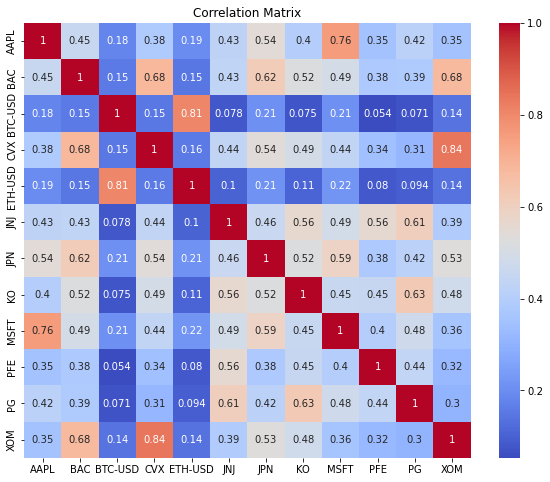

In [53]:
corr_matrix = portfolio_returns['Adj Close'].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Here we calculate random porfolio for comparison purposes because later we will use monte carlo simulation which will help us
to find better portfolio

In [54]:
np.random.seed(1)
num_stocks = portfolio_data.shape[1]
# Weight each security
weights = np.random.random((num_stocks,1))
# normalize it, so that sum is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(portfolio_data / portfolio_data.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Risk-free Rate
risk_free_rate = yf.Ticker('^TNX').history(period='1d', start='2018-01-01', end=None)['Close'].mean() / 100

# Sharpe ratio
sr = (exp_ret - risk_free_rate) / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [9.81065022e-02 1.69459922e-01 2.69072450e-05 7.11252425e-02
 3.45250537e-02 2.17231140e-02 4.38186418e-02 8.12948809e-02
 9.33415231e-02 1.26759318e-01 9.86175959e-02 1.61201298e-01]

Expected return of the portfolio is : 0.14886208724840527

Volatility of the portfolio: 0.22204922437064398

Sharpe ratio of the portfolio: 0.5727807521813998


# Monte Carlo Simulation

We simply randomize the security weights and compare the returns to the risks. And from among these weights, we will choose the one with the best return for a given risk. In this part, as an example, our Monte Carlo has 50,000 simulations but it
is not enough because the number of combinations increases exponentially. as the number of assets increases in the portfolio. Basically, the number of simulation increase as 101^n where n is the number of assets in the portfolio. Portfolio with 12 asset types mathematically should have at least 1.126825e+24 simulations, but it is impossible even with super computers. In practice
most of times quants do not run huge number of simulations. It's worth noting that the precise number of simulations used by quants can depend on factors such as computational resources, time constraints, and the level of precision required by the specific problem or model. Quants aim to strike a balance between accuracy and computational efficiency to meet their objectives effectively.

In [55]:
# number of simulation
n = 50000
# n = 10

port_weights = np.zeros(shape=(n,len(portfolio_data.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)


for i in range(n):
    weights = np.random.random(num_stocks)
    # normalize it, so that sum is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol

    # Sharpe ratio
    sr = (exp_ret - risk_free_rate) / exp_vol
    port_sr[i] = sr

In [56]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max Sharp Ratio
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]

# Index of min Volatility
min_vol = port_volatility.min()
ind_min_vol = port_volatility.argmin()
# Return and Sharp Ratio at min Volatility
min_vol_return = port_return[ind_min_vol]
min_vol_sr = (min_vol_return - risk_free_rate) / min_vol

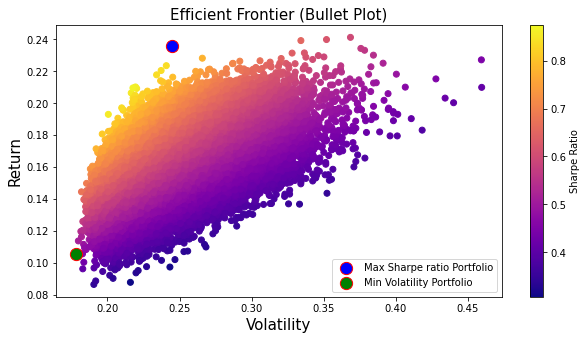

In [57]:
plt.figure(figsize=(10,5))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.scatter(min_vol, min_vol_return, c='green', s=150, edgecolors='red', marker='o', label='Min \
Volatility Portfolio')
plt.legend();

Here we can see outputs of Max Sharp Ratio Portfolio:

In [58]:
print("Max Sharp Ratio Portfolio :")
print("Sharp Ratio is", max_sr)
print("Return is", max_sr_ret)
print("Volatility is", max_sr_vol)

Max Sharp Ratio Portfolio :
Sharp Ratio is 0.8741884936482686
Return is 0.23593436399841713
Volatility is 0.24509336380322203


Suggested weights of assets within portfolio:

In [59]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

16.08 % of AAPL should be bought.
3.94 % of BAC should be bought.
11.92 % of BTC-USD should be bought.
0.45 % of CVX should be bought.
3.01 % of ETH-USD should be bought.
0.48 % of JNJ should be bought.
1.15 % of JPN should be bought.
1.69 % of KO should be bought.
29.04 % of MSFT should be bought.
28.81 % of PFE should be bought.
3.3 % of PG should be bought.
0.14 % of XOM should be bought.


Here we can see outputs of Min Volatility Portfolio:

In [60]:
print("Min Volatility Portfolio :")
print("Sharp Ratio is", min_vol_sr)
print("Return is", min_vol_return)
print("Volatility is", min_vol)

Min Volatility Portfolio :
Sharp Ratio is 0.47148904079929566
Return is 0.1056561217069037
Volatility is 0.17811560597982354


Suggested weights of assets within portfolio:

In [61]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind_min_vol],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

4.84 % of AAPL should be bought.
0.56 % of BAC should be bought.
1.77 % of BTC-USD should be bought.
6.55 % of CVX should be bought.
1.16 % of ETH-USD should be bought.
17.18 % of JNJ should be bought.
22.75 % of JPN should be bought.
19.93 % of KO should be bought.
5.25 % of MSFT should be bought.
14.61 % of PFE should be bought.
1.84 % of PG should be bought.
3.55 % of XOM should be bought.


# Now we will find the optimal portfolio based on the risk aversion of user

In this case the optimal portfolio based on the risk aversion of users. If the risk aversion of users is high they will type
low volatility, but if the risk aversion of users is low then they will type high volatility to get high return.

In [64]:
vol_range = input("Enter your desired volatility range in the format 'min-max': ")
min_vol, max_vol = map(float, vol_range.split('-'))
ind_user_vol = np.where((port_volatility >= min_vol) & (port_volatility <= max_vol))[0]
if len(ind_user_vol) == 0:
    print("No portfolios found within the specified volatility range.")
else:
    max_return_index = np.argmax(port_return[ind_user_vol])
    user_vol_return = port_return[ind_user_vol][max_return_index]
    user_vol = port_volatility[ind_user_vol][max_return_index]
    user_vol_sr = (user_vol_return - risk_free_rate) / user_vol

Enter your desired volatility range in the format 'min-max': 0.19-0.195


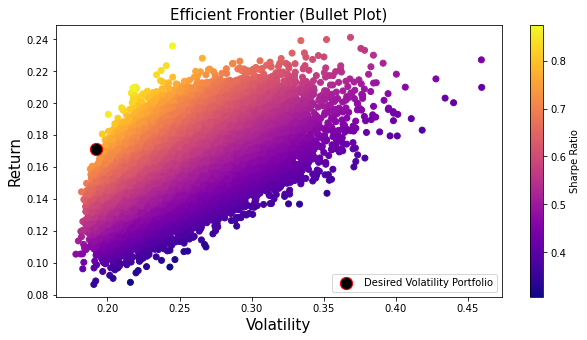

In [65]:
plt.figure(figsize=(10,5))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(user_vol, user_vol_return, c='black', s=150, edgecolors='red', marker='o', label='Desired Volatility Portfolio')
plt.legend();

Here we can see outputs based on risk aversion of users:

In [66]:
print("Desired Volatility Portfolio :")
print("Sharp Ratio is", user_vol_sr)
print("Return is", user_vol_return)
print("Given Volatility is", user_vol)

Desired Volatility Portfolio :
Sharp Ratio is 0.7799898450915383
Return is 0.17154869440722836
Given Volatility is 0.19214625659331272


Suggested weights of assets within portfolio:

In [67]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind_user_vol].flatten(), stocks):
    print(f'{round(float(weight) * 100, 2)} % of {stock} should be bought.')

5.66 % of AAPL should be bought.
1.2 % of BAC should be bought.
5.01 % of BTC-USD should be bought.
15.77 % of CVX should be bought.
1.72 % of ETH-USD should be bought.
3.39 % of JNJ should be bought.
16.86 % of JPN should be bought.
9.72 % of KO should be bought.
6.35 % of MSFT should be bought.
14.09 % of PFE should be bought.
19.41 % of PG should be bought.
0.82 % of XOM should be bought.
